In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
import astropy
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import (ImageNormalize, AsinhStretch,
                                    LinearStretch)
import astropy.constants as const
import astropy.units as u
from astropy.time import Time
from scipy.io import readsav
import sunpy
import sunpy.map
from sjireader import read_iris_sji
import cmcrameri.cm as cmcm
from sunkit_image import coalignment
from sun_blinker import SunBlinker
import iris_spec_recon
import importlib
importlib.reload(iris_spec_recon)
from iris_spec_recon import iris_spec_map_interp_from_header
from fancy_colorbar import plot_colorbar

In [2]:
SiIV_1393_fitres_file = readsav("../../src/IRIS/20221026/0026/fit_res/SiIV_1393_raster0.sav",verbose=True)

--------------------------------------------------
Date: Fri Aug 23 18:03:57 2024
User: yjzhu
Host: NB-RES-YINGJIE
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.8.3
--------------------------------------------------
Successfully read 12 records of which:
 - 1 are of type VERSION
 - 9 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - int [<class 'numpy.ndarray'>]
 - int_err [<class 'numpy.ndarray'>]
 - vel [<class 'numpy.ndarray'>]
 - vel_err [<class 'numpy.ndarray'>]
 - wid [<class 'numpy.ndarray'>]
 - wid_err [<class 'numpy.ndarray'>]
 - chi2 [<class 'numpy.ndarray'>]
 - refwvl [<class 'numpy.ndarray'>]
 - wave_corr_fuv [<class 'numpy.ndarray'>]
--------------------------------------------------


In [3]:
iris_raster_filename = "../../src/IRIS/20221026/0026/iris_l2_20221026_002630_3600609177_raster_t000_r00000.fits"

In [4]:
raster_header_0 = fits.getheader(iris_raster_filename,ext=0)
raster_header_SiIV = fits.getheader(iris_raster_filename,ext=3)
raster_header_CII = fits.getheader(iris_raster_filename,ext=1)
raster_header_MgII = fits.getheader(iris_raster_filename,ext=7)

In [5]:
SiIV_1393_fitres_file["wid"].shape

(548, 320)

In [6]:
SiIV_1393_mask = (np.abs(SiIV_1393_fitres_file["wid_err"]/SiIV_1393_fitres_file["wid"]) > 0.5) | \
                (SiIV_1393_fitres_file["wid"] < 0.04) | \
                (np.abs(SiIV_1393_fitres_file["int_err"]/SiIV_1393_fitres_file["int"]) > 0.5) | \
                (np.abs(SiIV_1393_fitres_file["vel_err"]) > 10 )


In [7]:
SiIV_1393_int_map = iris_spec_map_interp_from_header(iris_raster_filename,
                    win_ext=3,data=SiIV_1393_fitres_file["int"].copy(), tr_mode="off")
SiIV_1393_int_map.plot_settings["cmap"] = "irissji1400"
SiIV_1393_int_map.plot_settings["norm"] = ImageNormalize(vmin=0,vmax=1e4,stretch=AsinhStretch(0.1))
SiIV_1393_int_map.meta["rsun_ref"] = 696000000.0

For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


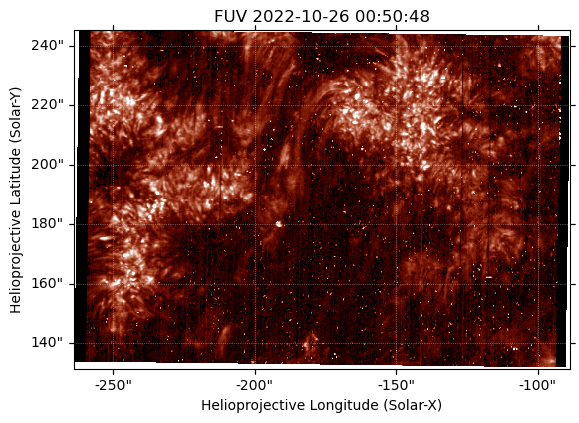

In [8]:
SiIV_1393_int_map.plot()

In [9]:
SiIV_1393_vel_map = iris_spec_map_interp_from_header(iris_raster_filename,
                    win_ext=3,data=SiIV_1393_fitres_file["vel"] + SiIV_1393_fitres_file["wave_corr_fuv"][np.newaxis,:]/1393.755*const.c.to_value(u.km/u.s),
                    mask=SiIV_1393_mask, tr_mode="off")
SiIV_1393_vel_map.plot_settings["cmap"] = "coolwarm"
SiIV_1393_vel_map.plot_settings["norm"] = ImageNormalize(vmin=-30,vmax=30)
SiIV_1393_vel_map.meta["rsun_ref"] = 696000000.0

In [10]:
SiIV_1393_veff = np.sqrt(SiIV_1393_fitres_file["wid"]**2 - (25.85e-3)**2)/1393.755/np.sqrt(4*np.log(2))*const.c.to_value(u.km/u.s)
SiIV_1393_vth2 = np.sqrt(2*const.k_B*10**4.9*u.K/const.u/28.0855).to_value(u.km/u.s)
SiIV_1393_vnth = np.sqrt(SiIV_1393_veff**2 - SiIV_1393_vth2**2)
SiIV_1393_vnth_map = iris_spec_map_interp_from_header(iris_raster_filename,
                    win_ext=3,data=SiIV_1393_vnth,
                    mask=SiIV_1393_mask, tr_mode="off")
SiIV_1393_vnth_map.plot_settings["cmap"] = cmcm.batlowK
SiIV_1393_vnth_map.plot_settings["norm"] = ImageNormalize(vmin=10,vmax=35)
SiIV_1393_vnth_map.meta["rsun_ref"] = 696000000.0

/tmp/ipykernel_230622/2903594028.py:3: RuntimeWarning: invalid value encountered in sqrt
  SiIV_1393_vnth = np.sqrt(SiIV_1393_veff**2 - SiIV_1393_vth2**2)


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


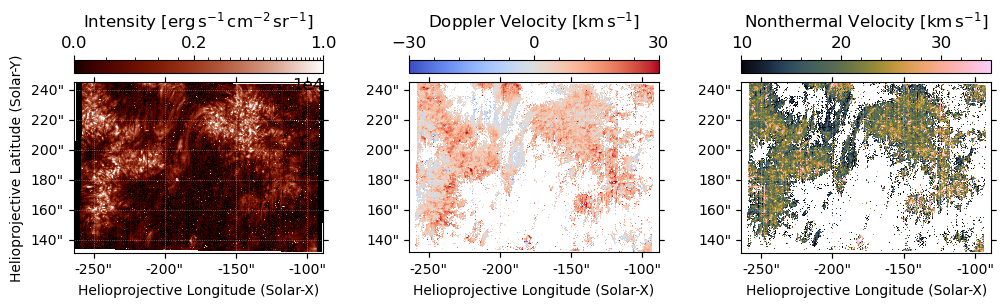

In [11]:
fig = plt.figure(figsize=(10,8),layout="constrained")

ax1 = fig.add_subplot(131,projection=SiIV_1393_int_map)
im1 = SiIV_1393_int_map.plot(axes=ax1)
clb1, clb_ax1 = plot_colorbar(im1,ax1,fontsize=12,
              bbox_to_anchor=(0,1.05,1,0.08),
              orientation="horizontal")
clb_ax1.tick_params(which="both",top=True,labeltop=True,labelbottom=False,bottom=False,labelsize=12)
clb_ax1.set_xticks([0,2000,10000])
ax1.set_title(r"Intensity [$\rm erg\,s^{-1}\,cm^{-2}\,sr^{-1}$]",fontsize=12,pad=40)


ax2 = fig.add_subplot(132,projection=SiIV_1393_vel_map)
im2 = SiIV_1393_vel_map.plot(axes=ax2)
clb2, clb_ax2 = plot_colorbar(im2,ax2,fontsize=12,
              bbox_to_anchor=(0,1.05,1,0.08),
              orientation="horizontal")
clb_ax2.tick_params(which="both",top=True,labeltop=True,labelbottom=False,bottom=False,labelsize=12)
clb_ax2.set_xticks([-30,0,30])
ax2.set_title(r"Doppler Velocity [$\rm km\,s^{-1}$]",fontsize=12,pad=40)

ax3 = fig.add_subplot(133,projection=SiIV_1393_vnth_map)
im3 = SiIV_1393_vnth_map.plot(axes=ax3)
clb3, clb_ax3 = plot_colorbar(im3,ax3,fontsize=12,
              bbox_to_anchor=(0,1.05,1,0.08),
              orientation="horizontal")
clb_ax3.tick_params(which="both",top=True,labeltop=True,labelbottom=False,bottom=False,labelsize=12)
ax3.set_title(r"Nonthermal Velocity [$\rm km\,s^{-1}$]",fontsize=12,pad=40)

for ax_ in (ax2,ax3):
    ax_.set_ylabel(' ')

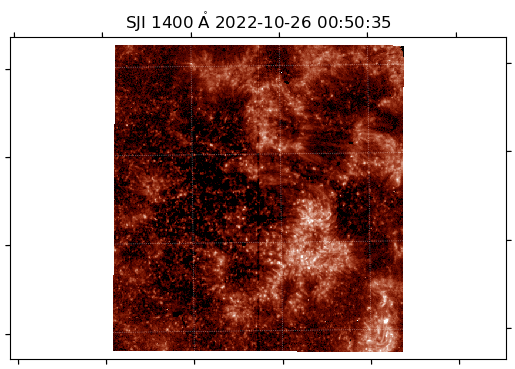

In [12]:
iris_1400_sji_map = read_iris_sji("../../src/IRIS/20221026/0026/iris_l2_20221026_002630_3600609177_SJI_1400_t000.fits",
                                        index=SiIV_1393_int_map.date,sdo_rsun=True)
iris_1400_sji_map.plot_settings["cmap"] = "irissji1400"
iris_1400_sji_map.plot_settings["norm"] = ImageNormalize(vmin=10,vmax=200,stretch=AsinhStretch(0.05))
iris_1400_sji_map.plot()

In [13]:
SunBlinker(SiIV_1393_int_map, iris_1400_sji_map, reproject=True)

In [27]:
SiIV_1393_int_map.save("../../src/IRIS/20221026/0026/fit_res/SiIV_1393_int_map.fits",overwrite=True)
SiIV_1393_vel_map.save("../../src/IRIS/20221026/0026/fit_res/SiIV_1393_vel_map.fits",overwrite=True)
SiIV_1393_vel_map_no_mask = sunpy.map.Map(SiIV_1393_fitres_file["vel"] + SiIV_1393_fitres_file["wave_corr_fuv"][np.newaxis,:]/1393.755*const.c.to_value(u.km/u.s), 
                                          SiIV_1393_vel_map.meta)
SiIV_1393_vel_map_no_mask.save("../../src/IRIS/20221026/0026/fit_res/SiIV_1393_vel_map_no_mask.fits",overwrite=True)
SiIV_1393_vnth_map.save("../../src/IRIS/20221026/0026/fit_res/SiIV_1393_vnth_map.fits",overwrite=True)

In [15]:
CII_fitres_file = readsav("../../src/IRIS/20221026/0026/fit_res/CII_1334_raster0.sav",verbose=True)

--------------------------------------------------
Date: Fri Aug 23 18:21:53 2024
User: yjzhu
Host: NB-RES-YINGJIE
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.8.3
--------------------------------------------------
Successfully read 12 records of which:
 - 1 are of type VERSION
 - 9 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - int [<class 'numpy.ndarray'>]
 - int_err [<class 'numpy.ndarray'>]
 - vel [<class 'numpy.ndarray'>]
 - vel_err [<class 'numpy.ndarray'>]
 - wid [<class 'numpy.ndarray'>]
 - wid_err [<class 'numpy.ndarray'>]
 - chi2 [<class 'numpy.ndarray'>]
 - refwvl [<class 'numpy.ndarray'>]
 - wave_corr_fuv [<class 'numpy.ndarray'>]
--------------------------------------------------


In [16]:
CII_1334_mask = (np.abs(CII_fitres_file["wid_err"]/CII_fitres_file["wid"]) > 0.5) | \
                (CII_fitres_file["wid"] < 0.03) | \
                (np.abs(CII_fitres_file["int_err"]/CII_fitres_file["int"]) > 0.5) | \
                (np.abs(CII_fitres_file["vel_err"]) > 10 )

In [17]:
CII_int_map = iris_spec_map_interp_from_header(iris_raster_filename,
                    win_ext=1,data=CII_fitres_file["int"].copy(), tr_mode="off")
CII_int_map.plot_settings["cmap"] = "irissji1330"
CII_int_map.plot_settings["norm"] = ImageNormalize(vmin=0,vmax=1e4,stretch=AsinhStretch(0.1))
CII_int_map.meta["rsun_ref"] = 696000000.0

CII_vel_map = iris_spec_map_interp_from_header(iris_raster_filename,
                    win_ext=1,data=CII_fitres_file["vel"] + CII_fitres_file["wave_corr_fuv"][np.newaxis,:]/1334.5323*const.c.to_value(u.km/u.s),
                    mask=CII_1334_mask, tr_mode="off")
CII_vel_map.plot_settings["cmap"] = "RdBu_r"
CII_vel_map.plot_settings["norm"] = ImageNormalize(vmin=-30,vmax=30)
CII_vel_map.meta["rsun_ref"] = 696000000.0

CII_veff = np.sqrt(CII_fitres_file["wid"]**2 - (17.03e-3)**2)/1334.532/np.sqrt(4*np.log(2))*const.c.to_value(u.km/u.s)
CII_vth2 = np.sqrt(2*const.k_B*10**4.9*u.K/const.u/12.0107).to_value(u.km/u.s)
CII_vnth = np.sqrt(CII_veff**2 - CII_vth2**2)
CII_vnth_map = iris_spec_map_interp_from_header(iris_raster_filename,
                    win_ext=1,data=CII_vnth,
                    mask=CII_1334_mask, tr_mode="off")
CII_vnth_map.plot_settings["cmap"] = cmcm.batlowK
CII_vnth_map.plot_settings["norm"] = ImageNormalize(vmin=5,vmax=30)
CII_vnth_map.meta["rsun_ref"] = 696000000.0


/tmp/ipykernel_230622/1627915721.py:16: RuntimeWarning: invalid value encountered in sqrt
  CII_vnth = np.sqrt(CII_veff**2 - CII_vth2**2)


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


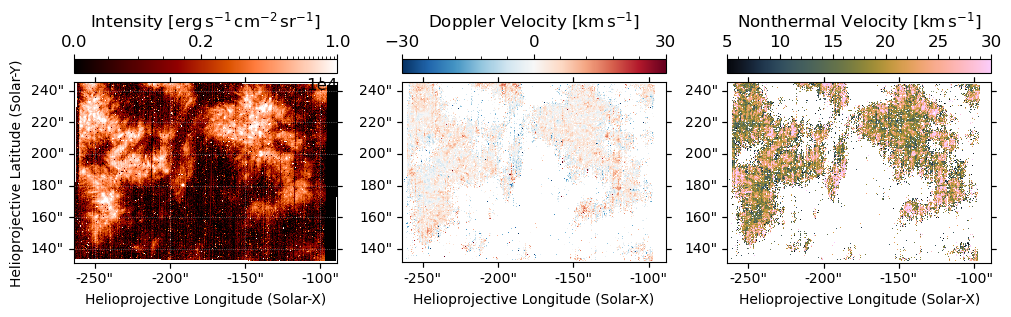

In [18]:
fig = plt.figure(figsize=(10,8),layout="constrained")

ax1 = fig.add_subplot(131,projection=CII_int_map)
im1 = CII_int_map.plot(axes=ax1)
clb1, clb_ax1 = plot_colorbar(im1,ax1,fontsize=12,
              bbox_to_anchor=(0,1.05,1,0.08),
              orientation="horizontal")
clb_ax1.tick_params(which="both",top=True,labeltop=True,labelbottom=False,bottom=False,labelsize=12)
clb_ax1.set_xticks([0,2000,10000])
ax1.set_title(r"Intensity [$\rm erg\,s^{-1}\,cm^{-2}\,sr^{-1}$]",fontsize=12,pad=40)

ax2 = fig.add_subplot(132,projection=CII_vel_map)
im2 = CII_vel_map.plot(axes=ax2)
clb2, clb_ax2 = plot_colorbar(im2,ax2,fontsize=12,
              bbox_to_anchor=(0,1.05,1,0.08),
              orientation="horizontal")
clb_ax2.tick_params(which="both",top=True,labeltop=True,labelbottom=False,bottom=False,labelsize=12)
clb_ax2.set_xticks([-30,0,30])
ax2.set_title(r"Doppler Velocity [$\rm km\,s^{-1}$]",fontsize=12,pad=40)

ax3 = fig.add_subplot(133,projection=CII_vnth_map)
im3 = CII_vnth_map.plot(axes=ax3)
clb3, clb_ax3 = plot_colorbar(im3,ax3,fontsize=12,
              bbox_to_anchor=(0,1.05,1,0.08),
              orientation="horizontal")
clb_ax3.tick_params(which="both",top=True,labeltop=True,labelbottom=False,bottom=False,labelsize=12)
ax3.set_title(r"Nonthermal Velocity [$\rm km\,s^{-1}$]",fontsize=12,pad=40)

for ax_ in (ax2,ax3):
    ax_.coords[1].axislabels.set_visible(False)



In [19]:
CII_int_map.save("../../src/IRIS/20221026/0026/fit_res/CII_int_map.fits",overwrite=True)
CII_vel_map.save("../../src/IRIS/20221026/0026/fit_res/CII_vel_map.fits",overwrite=True)

In [20]:
CII_int_map.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 
CRVAL : -0.048977432668261 0.052371163267634 
CRPIX : 251.0 172.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 9.7185136270321e-05 9.2434488356437e-05 
NAXIS : 501  342

In [21]:
iris2model = readsav('../../src/IRIS/20221026/0026/fit_res/iris2model_20221026_002630_3600609177_raster_t000_r00000.sav',verbose=True)['iris2model'][0]

--------------------------------------------------
Date: Mon Aug 26 10:58:23 2024
User: yjzhu
Host: NB-RES-YINGJIE
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.8.3
--------------------------------------------------
Successfully read 4 records of which:
 - 1 are of type VERSION
 - 1 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - iris2model [<class 'numpy.recarray'>]
--------------------------------------------------


In [22]:
ltau = iris2model["ltau"]
atmos = iris2model["model"]
Te, vlos, vturb, Ne = atmos

In [23]:
ltau_aver_index = np.where((ltau >= - 4.61) & (ltau <= -4.19))[0]
ltau_aver_index

array([15, 16, 17])

In [24]:
Te_interp, irisspec_wcs = iris_spec_map_interp_from_header(iris_raster_filename,
                                                          data=Te.transpose(1,2,0),win_ext=7,
                                                          tr_mode="off")
Ne_interp, irisspec_wcs = iris_spec_map_interp_from_header(iris_raster_filename,
                                                          data=Ne.transpose(1,2,0),win_ext=7,
                                                          tr_mode="off")
vlos_interp, irisspec_wcs = iris_spec_map_interp_from_header(iris_raster_filename,
                                                          data=vlos.transpose(1,2,0),win_ext=7,
                                                          tr_mode="off")
vturb_interp, irisspec_wcs = iris_spec_map_interp_from_header(iris_raster_filename,
                                                          data=vturb.transpose(1,2,0),win_ext=7,
                                                          tr_mode="off")

In [25]:
iris2_Te_map = sunpy.map.Map(np.nanmean(Te_interp[:,:,ltau_aver_index], axis=-1), irisspec_wcs)
iris2_Te_map = iris2_Te_map.rotate()
iris2_Te_map.plot_settings["cmap"] = cmcm.batlowK
iris2_Te_map.meta["rsun_ref"] = 696000000.0

iris2_Ne_map = sunpy.map.Map(np.nanmean(Ne_interp[:,:,ltau_aver_index], axis=-1), irisspec_wcs)
iris2_Ne_map.plot_settings["cmap"] = cmcm.batlowK
iris2_Ne_map.meta["rsun_ref"] = 696000000.0

iris2_vlos_map = sunpy.map.Map(np.nanmean(vlos_interp[:,:,ltau_aver_index], axis=-1), irisspec_wcs)
iris2_vlos_map.norm = ImageNormalize(vmin=-30,vmax=30,)
iris2_vlos_map.plot_settings["cmap"] = "coolwarm"
iris2_vlos_map.meta["rsun_ref"] = 696000000.0

iris2_vturb_map = sunpy.map.Map(np.nanmean(vturb_interp[:,:,ltau_aver_index], axis=-1), irisspec_wcs)
iris2_vturb_map.norm = ImageNormalize(vmin=0,vmax=30,)
iris2_vturb_map.plot_settings["cmap"] = cmcm.batlowK
iris2_vturb_map.meta["rsun_ref"] = 696000000.0

/tmp/ipykernel_230622/1302839850.py:1: RuntimeWarning: Mean of empty slice
  iris2_Te_map = sunpy.map.Map(np.nanmean(Te_interp[:,:,ltau_aver_index], axis=-1), irisspec_wcs)
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]
/tmp/ipykernel_230622/1302839850.py:6: RuntimeWarning: Mean of empty slice
  iris2_Ne_map = sunpy.map.Map(np.nanmean(Ne_interp[:,:,ltau_aver_index], axis=-1), irisspec_wcs)
/tmp/ipykernel_230622/1302839850.py:10: RuntimeWarning: Mean of empty slice
  iris2_vlos_map = sunpy.map.Map(np.nanmean(vlos_interp[:,:,ltau_aver_index], axis=-1), irisspec_wcs)
/tmp/ipykernel_230622/1302839850.py:15: RuntimeWarning: Mean of empty slice
  iris2_vturb_map = sunpy.map.Map(np.nanmean(vturb_interp[:,:,ltau_aver_index], axis=-1), irisspec_wcs)


In [26]:
iris2_Te_map.save("../../src/IRIS/20221026/0026/fit_res/iris2_Te_map.fits",overwrite=True)
iris2_Ne_map.save("../../src/IRIS/20221026/0026/fit_res/iris2_Ne_map.fits",overwrite=True)
iris2_vlos_map.save("../../src/IRIS/20221026/0026/fit_res/iris2_vlos_map.fits",overwrite=True)
iris2_vturb_map.save("../../src/IRIS/20221026/0026/fit_res/iris2_vturb_map.fits",overwrite=True)

For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


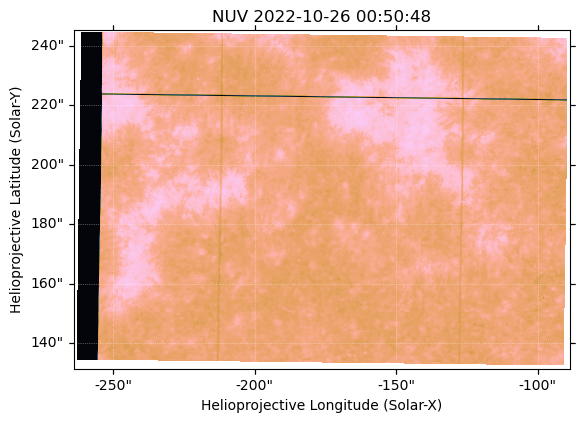

In [28]:
iris2_Te_map.plot()

In [30]:
SunBlinker(iris2_Te_map, iris_1400_sji_map, reproject=True)

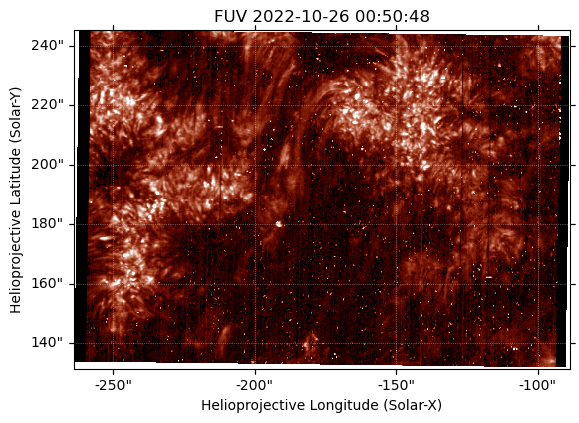

In [29]:
SiIV_1393_int_map.plot()